In [44]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product, cycle
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidierectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import plotly.offline as py
import plotly.graph_objects as gof
import plotly.express as px
from plotly.subplots import make_subplots

## Load the CSV files and concat them

In [2]:
file1 = 'BTC_Data_1.csv'
file2 = 'BTC_Data_2.csv'
file3 = 'BTC_Data_3.csv'
file4 = 'BTC_Data_4.csv'

In [3]:
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

In [4]:
btc_df = pd.concat([df1, df2, df3, df4])

In [5]:
btc_df.tail()

,time,low,high,open,close,volume
1049378,2024-05-30 23:56:00,68360.32,68384.00,68360.33,68381.62,1.046278
1049379,2024-05-30 23:57:00,68363.82,68381.62,68381.62,68377.78,3.404394
1049380,2024-05-30 23:58:00,68351.24,68377.78,68377.78,68362.24,1.725811
1049381,2024-05-30 23:59:00,68328.03,68360.87,68359.36,68338.58,2.216593
1049382,2024-05-31 00:00:00,68325.00,68360.96,68338.58,68356.11,1.952034


In [6]:
btc_df.shape

(4172271, 6)

In [7]:
btc_df.describe()

,low,high,open,close,volume
count,4.172271e+06,4.172271e+06,4.172271e+06,4.172271e+06,4.172271e+06
mean,1.994350e+04,1.996432e+04,1.995403e+04,1.995409e+04,1.071346e+01
std,1.836580e+04,1.838674e+04,1.837632e+04,1.837637e+04,2.185372e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,8.000000e-08
25%,6.315350e+03,6.319980e+03,6.317830e+03,6.317850e+03,1.791247e+00
50%,1.100899e+04,1.102347e+04,1.101665e+04,1.101700e+04,4.661913e+00
75%,3.055315e+04,3.057719e+04,3.056508e+04,3.056517e+04,1.140988e+01
max,7.371832e+04,7.383557e+04,7.381503e+04,7.381543e+04,1.549613e+03


In [8]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4172271 entries, 0 to 1049382
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 222.8+ MB


#### As we can see the data type of "time" column is 'object' we will convert it into 'float64' 

In [9]:
btc_df['time'] = pd.to_datetime(btc_df['time'])

In [10]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4172271 entries, 0 to 1049382
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 222.8 MB


In [11]:
print('Null Values:',btc_df.isnull().values.sum())
print('If any NA values:', btc_df.isnull().values.any())

Null Values: 0
If any NA values: False


## Plot of the entire 8 years BTC Data

<Axes: title={'center': 'Bitcoin Weighted Price'}, xlabel='time'>

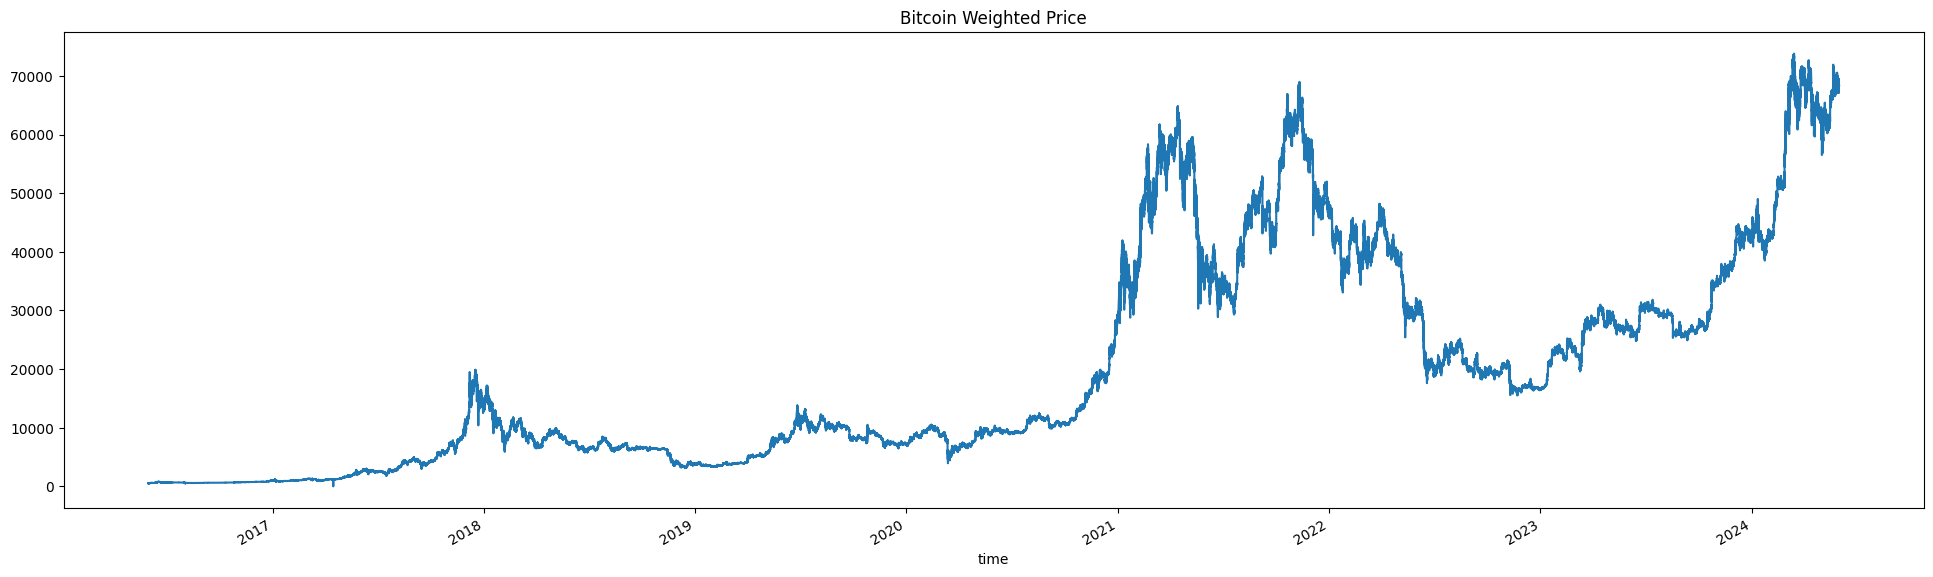

In [12]:
btc_df.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

We will make some **lag plots** to visualize the autocorrelation of BTC closing price at different time lags. A **lag** in a time-series data is how much one point is falling in time from another data point. If the order of lag is one, the lag is the previous data. If the order of lag is two, the lag is data point before two data points in time.<br>
These plots can help identify patterns, trends, and potential predictive relationships in the time series data. For example, if the points in a lag plot form a diagonal line, it indicates a strong autocorrelation at that lag.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


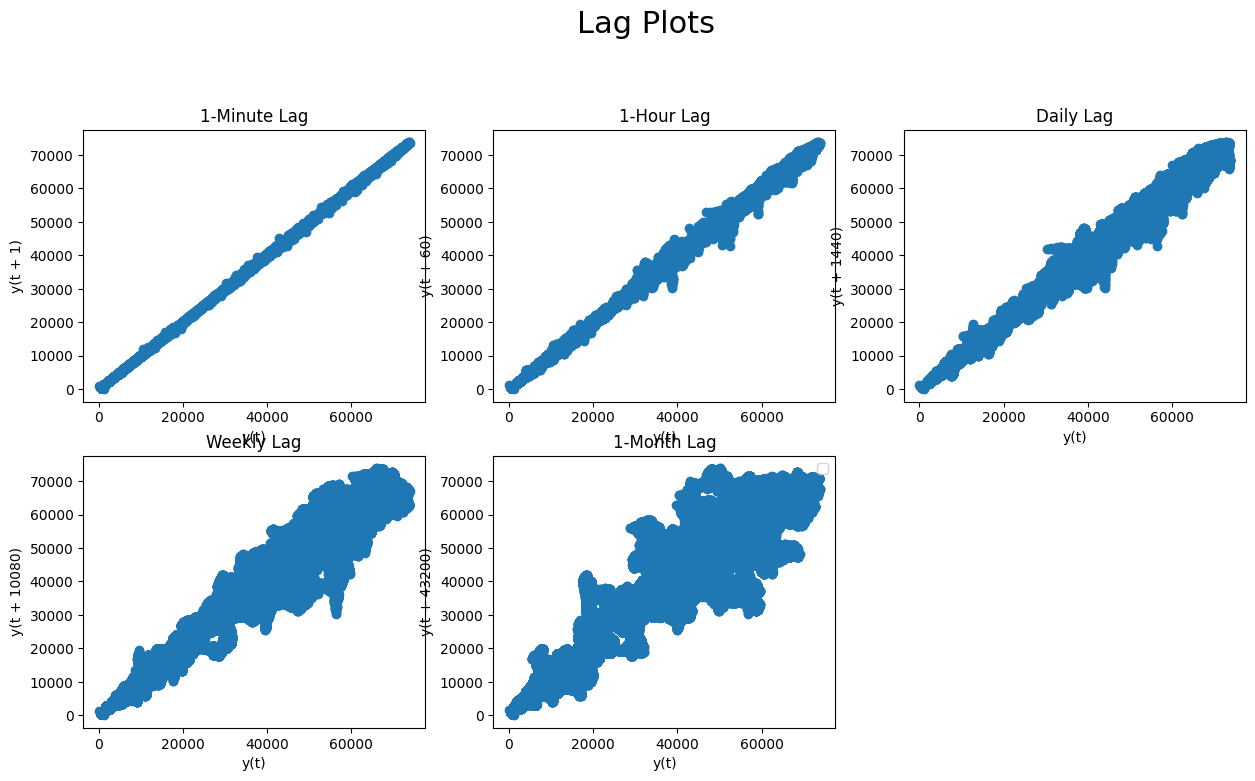

In [13]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_df['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_df['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_df['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_df['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_df['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

We can see the correlation is extremely high at 1 minute and we increase the lag order, the correlation becomes weak. At last there is no correlation at all. So we will group the data on daily basis means lag order will be 24 hours.

In [45]:
btc_df['date'] = pd.to_datetime(btc_df['time'],unit='s').dt.date

display(btc_df.head())

group = btc_df.groupby('date')

groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2016-05-31 00:00:00,532.56,532.78,532.56,532.78,7.85012,2016-05-31
1,2016-05-31 00:01:00,532.71,532.81,532.81,532.71,0.20950,2016-05-31
2,2016-05-31 00:02:00,532.73,532.82,532.73,532.82,1.52906,2016-05-31
3,2016-05-31 00:03:00,532.85,532.97,532.85,532.97,4.94657,2016-05-31
4,2016-05-31 00:04:00,532.49,533.25,532.49,533.25,5.72112,2016-05-31


#### Grouping the data with respect to the data column

In [46]:
display(groupby_date.head(10))

print("Length of groupby_date :", len(groupby_date))

date
2016-05-31    533.684574
2016-06-01    533.245138
2016-06-02    536.239000
2016-06-03    555.243833
2016-06-04    576.788654
2016-06-05    578.002186
2016-06-06    583.115042
2016-06-07    583.126190
2016-06-08    579.181246
2016-06-09    579.304649
Name: close, dtype: float64

Length of groupby_date : 2923


#### Now out of these 2923 days we will keep 120 days as test set and rest will be used for trianing

In [47]:
prediction_days = 120
df_train = groupby_date[:len(groupby_date)-prediction_days].values.reshape(-1,1)
df_test = groupby_date[len(groupby_date)-prediction_days:].values.reshape(-1,1)

In [48]:
df_test.shape

(120, 1)

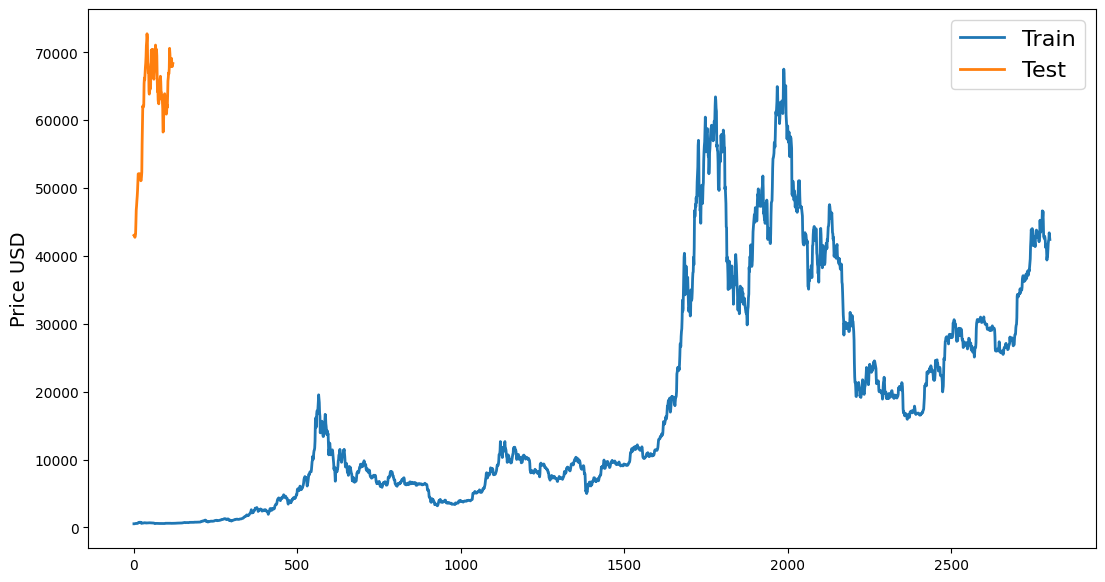

In [49]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

Scaling should be done after the train-test split, because if we split after scaling then there will be a leakage from the test set to the training set as the training process will get influenced by the test set as well.

By fitting the scaler only on the training data and then applying the same transformation to the test data, we ensure that the test data remains unseen during training, which preserves the integrity of our model evaluation.

After scaling all the values will be between 0 to 1

In [50]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

# Dataset Generation
Before training an LSTM model, it is necessary to prepare the time series data. For instance, a univariate time series can be represented as an observation vector:

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

A supervised learning algorithm requires data to be provided as a set of samples, where each sample consists of an input component **X** and an output component **y**. The model learns to map the input to the output based on the provided examples.

For time series data, this means converting the series into samples with input and output components. In a univariate time series problem focused on one-step forecasting, we can use observations from previous time points as input and the observation at the current time point as the output. For example, a 10-step univariate sequence can be expressed as a supervised learning problem where the input consists of 3 time steps and the output is 1 time step, as shown below:

[1, 2, 3, 4, 5], [6]

[2, 3, 4, 5, 6], [7]

[3, 4, 5, 6, 7], [8]

1,2,3,4,5 are inputs and 6 is taken as output, this as an input-output pair goes inside the network. Similarly for 2,3,4,5,6 and 7. So here we basically consider a **window of size 5**. That will shift forward by 1 unit/data point. 

We also need to define a **"lookback period"** which defines how many previous timesteps are used in order to predict the subsequent timestep. So if lookback is 5, that means we will be using timestep $t-4, t-3, t-2, t-1$ & $t$ to predict $t+1$.

In [51]:
def dataset_generator_lstm(dataset, look_back=5):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2798, 5)
trainY:  (2798,)
testX:  (115, 5)
testY (115,)


## Restructuring of the Dataset
For LSTM we need to reshape the input data into a 3d Tensor:<br>
**[samples, time_steps, features]**

**samples** - length/amount of input data points.<br>
**time_steps** - width of the sliding window equivalent to the amount of time steps we run our network.<br>
**features** - amount of features in every time step.

So if we are observing the amount of rain and the temperature each hour for 24 hours in order to predict the weather, and we do this for 365 days. We will have **365 samples**, each of which will have **24 timesteps** and **2 variables** (one for rain, one for temperature).

**Example:** we have data : [1,2,3,4,5,6,7,8,9,10] each data point is a single time step. So to run LSTM on this data we need to restructure it as single input sample where we have one sequence of multiple time step and one feature.<br>
```python
data = np.array([1,2,3,4,5,6,7,8,9,10])
data = data.reshape((1,10,1))
```

In [52]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (2798, 5, 1)
Shape of testX:  (115, 5, 1)


In [53]:
print("Time steps in input_shape:", trainX.shape[1])
print("n_features in input_shape:", trainX.shape[2])

Time steps in input_shape: 5
n_features in input_shape: 1


## Creating the LSTM Model
The **input_shape** is supposed to be **(timesteps, n_features)**.<br>
The **return_sequences** should be set to **True**. The original LSTM is comprised of single hidden LSTM layer followed by standard feed forward output layers. The stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells. So by setting `return_sequences=True` the second LSTM layer has a compatible n-dimensional sequence input.

Addition of layers adds levels of abstraction of input observation over time in effect chuncking observations over time or representing problems at differnet time scales.

### Why Increase Depth of an LSTM ?
Stacking LSTM hidden layers makes the model deeper, more accurately earning the description as a deep learning technique.

It is the depth of neural networks that is generally attributed to the success of the approach on a wide range of challenging prediction problems.

Additional hidden layers can be added to a Multilayer Perceptron neural network to make it deeper. The additional hidden layers are understood to recombine the learned representation from prior layers and create new representations at high levels of abstraction. For example, from lines to shapes to objects.

A sufficiently large single hidden layer Multilayer Perceptron can be used to approximate most functions. Increasing the depth of the network provides an alternate solution that requires fewer neurons and trains faster. Ultimately, adding depth it is a type of representational optimization.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

Stacked LSTMs are now a stable technique for challenging sequence prediction problems.

In [57]:
# regressor = Sequential()

# regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))

# regressor.add(Dense(units = 1))

# regressor.summary()

regressor = Sequential()

regressor.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=128, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=64, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=64, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=64, activation='relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.summary()

C:\Users\sayed\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 5, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 5, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 5, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 313,665 (1.20 MB)

 Trainable params: 313,665 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Since this is a regression type of problem we will be using **MSE** to evaluate the performance. We will use **Early Stopping** which will stop the training when a monitored metric (here 'val_loss') has stopped improving.

In [58]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'best_model.keras'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(trainX, trainY,
                        batch_size = 32, epochs = 600,
                        verbose=1, shuffle=False,
                        validation_data=(testX, testY),
                        callbacks=callbacks)

Epoch 1/600
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129
Epoch 1: val_loss improved from inf to 0.21593, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0138 - val_loss: 0.2159
Epoch 2/600
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0500
Epoch 2: val_loss improved from 0.21593 to 0.10432, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0511 - val_loss: 0.1043
Epoch 3/600
82/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0855
Epoch 3: val_loss did not improve from 0.10432
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0849 - val_loss: 0.1434
Epoch 4/600
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0706
Epoch 4: val_loss improved from 0.10432 to 0.02905, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0704 - val_loss: 0.0291
Epoch 5/600
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0545
Epoch 5: val_loss did not improve from 0.02905
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7m

In [59]:
model_from_saved_checkpoint = load_model(checkpoint_path)

## Plot Training Loss vs Validation Loss 
**val_loss** is the value of the cost function for the cross-validation data, while **loss** represents the cost function value for the training data. During validation, dropout is not applied, meaning that neurons do not randomly drop out. This is because dropout is used during training to introduce noise and help prevent overfitting. When evaluating on the validation data, we are in the inference phase, not the training phase, and therefore, we utilize the full capacity of the network without applying dropout.

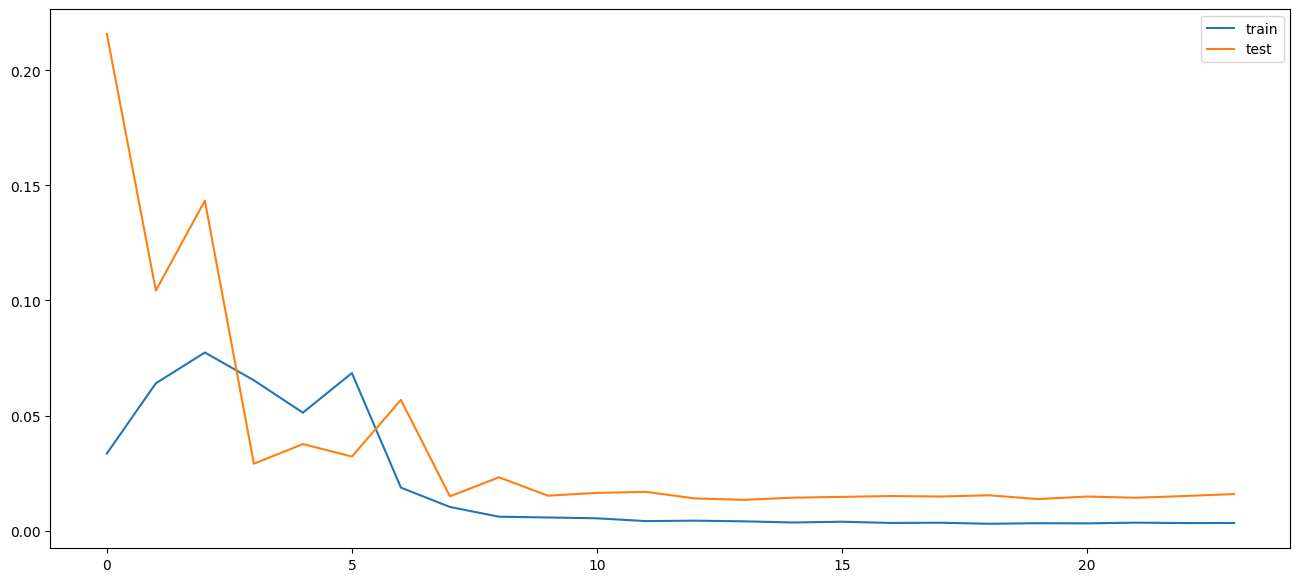

In [60]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Making Prediction
After prediction we need to convert the scaled values to the original price values. And for this we will use the **`.inverse_transform()`** method of sci-kit learn.

In [61]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


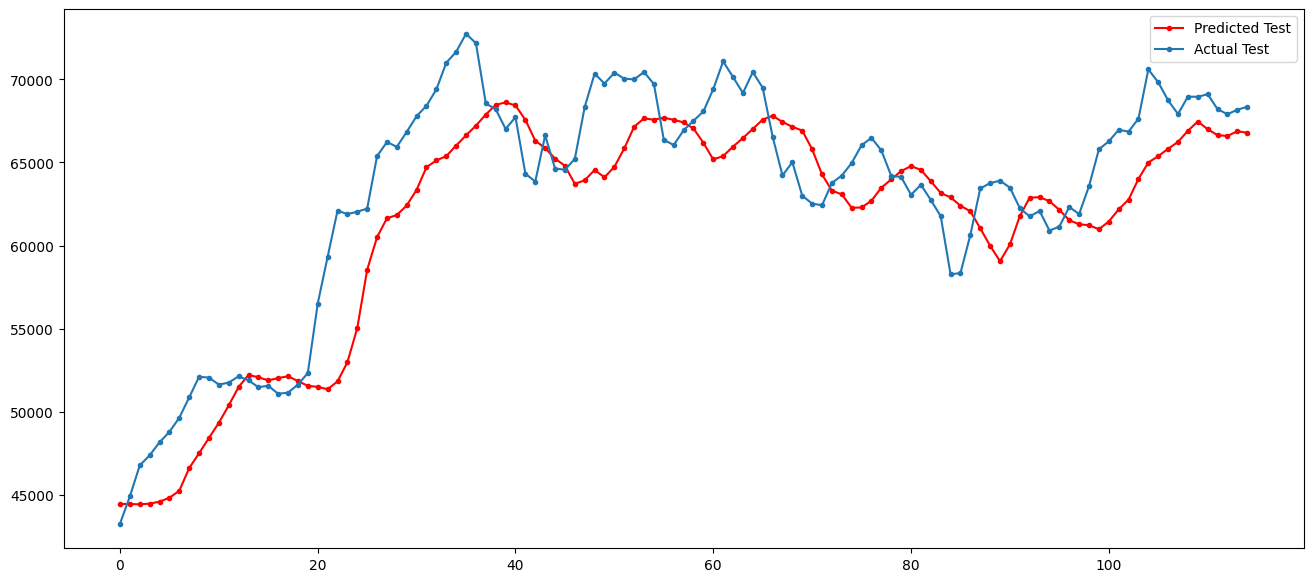

In [62]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

## Prediction on Train Set

In [63]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


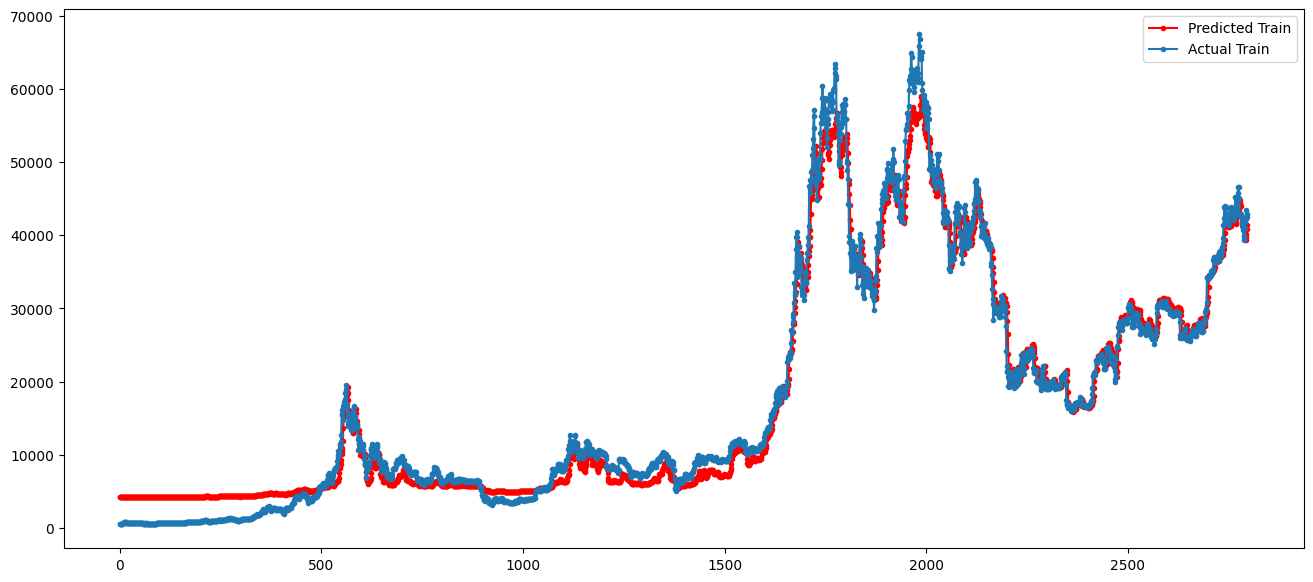

In [64]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

## Evaluating Performance on Train and Test Set

In [65]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))
print('RMSE on Test Set: %.3f' % rmse_lstm_test)

RMSE on Test Set: 3466.789


In [66]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))
print('RMSE on Train Set: %.3f' % rmse_lstm_train)

RMSE on Train Set: 2398.553


## Prediction on Future
We will try to make prediction on future 5 days, for this we will look back the previous 5 days. Note that the original data ended on 31-May-2024, but now we will be going to forecast the Bitcoin Prices for 5 days beyond 31-May-2024, using the trained LSTM model above.

In [67]:
lookback_period = 5
testX_last_5_days = testX[testX.shape[0] - lookback_period :]
testX_last_5_days.shape

(5, 5, 1)

In [68]:
testX_last_5_days

array([[[0.90255817],
        [0.86633493],
        [0.83896636],
        [0.87392356],
        [0.87350123]],

       [[0.86633493],
        [0.83896636],
        [0.87392356],
        [0.87350123],
        [0.87885637]],

       [[0.83896636],
        [0.87392356],
        [0.87350123],
        [0.87885637],
        [0.84855126]],

       [[0.87392356],
        [0.87350123],
        [0.87885637],
        [0.84855126],
        [0.83870113]],

       [[0.87350123],
        [0.87885637],
        [0.84855126],
        [0.83870113],
        [0.84744324]]])

In [69]:
predicted_5_days_forecast_price_test_x = []

for i in range(5):  
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])
  
  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
  
print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x)) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[67003.01]]

 [[66642.06]]

 [[66598.95]]

 [[66876.19]]

 [[66794.09]]]


In [70]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)
predicted_5_days_forecast_price_test_x.shape

(5, 1, 1)

In [71]:
predicted_btc_price_test_data.shape

(115, 1)

In [72]:
predicted_5_days_forecast_price_test_x

array([[[67003.01]],

       [[66642.06]],

       [[66598.95]],

       [[66876.19]],

       [[66794.09]]], dtype=float32)

In [73]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()
predicted_5_days_forecast_price_test_x

array([67003.01, 66642.06, 66598.95, 66876.19, 66794.09], dtype=float32)

In [74]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()
predicted_btc_price_test_data

array([44448.17 , 44443.816, 44428.934, 44467.465, 44586.76 , 44822.355,
       45240.754, 46606.098, 47501.71 , 48422.71 , 49334.668, 50377.434,
       51491.574, 52209.26 , 52076.77 , 51886.684, 52027.637, 52134.37 ,
       51842.656, 51558.113, 51497.77 , 51352.707, 51823.652, 52978.676,
       55037.914, 58547.004, 60503.566, 61645.04 , 61836.05 , 62417.863,
       63354.605, 64718.89 , 65122.793, 65382.082, 66020.49 , 66634.21 ,
       67217.586, 67886.68 , 68466.63 , 68617.9  , 68433.15 , 67566.14 ,
       66310.16 , 65867.05 , 65235.613, 64796.957, 63714.56 , 63927.324,
       64549.04 , 64109.71 , 64737.016, 65846.484, 67155.06 , 67654.445,
       67575.52 , 67696.15 , 67568.98 , 67413.55 , 67047.61 , 66186.53 ,
       65183.26 , 65385.277, 65955.56 , 66471.84 , 67021.88 , 67580.53 ,
       67814.08 , 67438.33 , 67147.04 , 66922.28 , 65795.9  , 64278.18 ,
       63307.438, 63081.066, 62274.633, 62291.305, 62700.957, 63483.746,
       63979.27 , 64485.676, 64781.055, 64556.184, 

In [75]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))
predicted_btc_test_concatenated.shape

(120,)

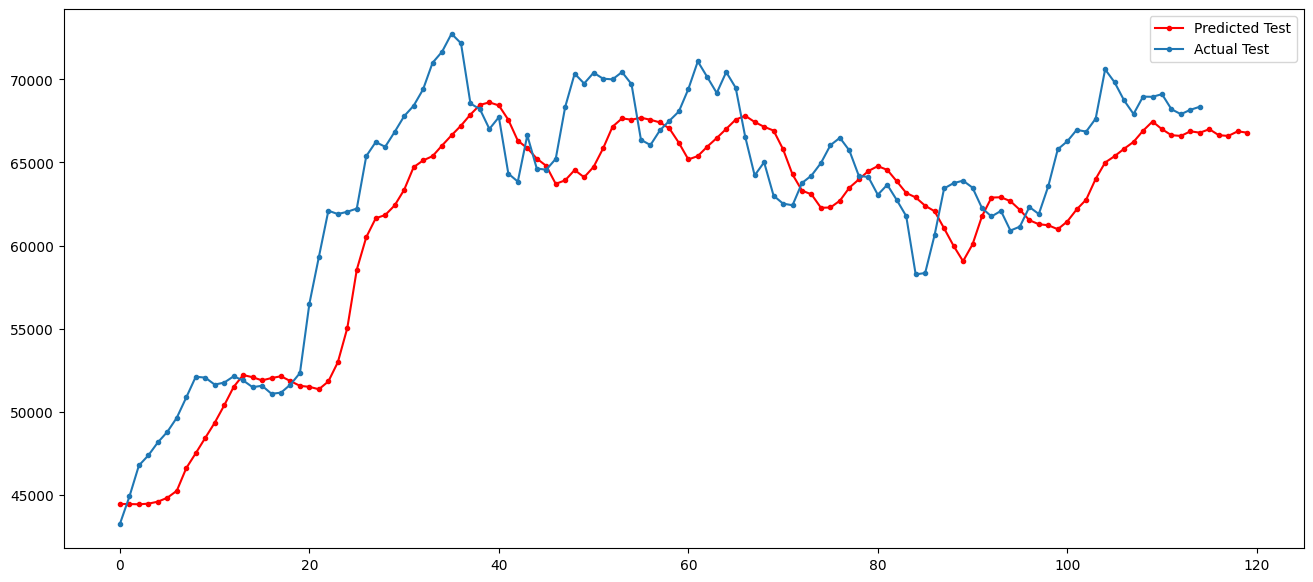

In [76]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()